# Modify aviation emissions
We use data from https://www.flightradar24.com/data/statistics to modify all NOx emissions. For the time period after this, the reduction factor reverts smoothly to 2/3rds the average for the last month we have data for, for the remainder of the 2 years, then returns to baseline. To represent this properly, additional years will be interpolated onto the data. 

Note that flightradar24 no longer reports the first few days of 2020 for free, so we update the data by adding rows rather than replacing the file. 

The consortium has so far agreed that only the NOx emissions from aircraft are important enough to model in this detail. If other emissions are desired, it would be necessary to change the variables `nox_input` and `key_variable` to the appropriate values for the new variable, after which the code could be run. 

In [1]:
from datetime import date, timedelta, datetime
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import pandas as pd


import os
import sys

sys.path.append(os.getcwd())
from utils import copy_netcdf_file, insert_interpolated_point, cutoff_netcdf_time, cleanup_files


Bad key "text.kerning_factor" on line 4 in
C:\Users\rlamboll\AppData\Local\Continuum\anaconda3\envs\netcfd-6\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


# Running options
Here are the options for loading files and hopefully the only things that will need to be changed to run the code on different data. Assuming the data is updated monthly, the first two options will need updating every time. Other options will only need updating if you want to do a different calculation. 

In [2]:
# String appended on the end of all files. Update with every successful run where the data will be used
# (both with data change and with protocol change). 
version_str = "_v4.nc"  # CHANGE ON UPDATE

# which month's data should we use to base the "long tail" of the reversion to baseline? As a 2-digit string.
# Update if we have enough data to use a later month as the baseline. 
month_plat = "06"  # CHANGE ON UPDATE

# variables for loading files
input_folder = "../input/"
output_folder = "../output/aviation/"
nox_input = "CO2-em-AIR-anthro_input4MIPs_emissions_ScenarioMIP_IAMC-MESSAGE-GLOBIOM-ssp245-1-1_gn_201501-210012.nc"
input_flights = "total-number-of-flights.csv"


scenario_string = "_flightrd_mp{}".format(month_plat)

def convert_years_to_days(year):  # Data is recorded in 365-day years
    return (year - 2015) * 365

# We don't want data after 2050.
tcutoff = convert_years_to_days(2050.99)
# name of the variable in the file
key_variable = "CO2_em_AIR_anthro"
# Years to interpolate, as number of years after 2015. 
yeardif_to_interpolate = [1, 2, 3, 4, 6, 7, 8, 9, 10]  
working_string = "_workings"

Only change lines below here if you know what you're doing. 
# Calculations begin

In [3]:
flights_change = pd.read_csv(input_folder + input_flights)
flights_change.tail(20)

,DateTime,7-day moving average,Number of flights
171,25/06/2020,126695,139183
172,26/06/2020,127798,135951
173,27/06/2020,127133,113899
174,28/06/2020,126135,105289
175,29/06/2020,125444,116337
176,30/06/2020,125065,125957
177,01/07/2020,124285,133384
178,02/07/2020,124823,142950
179,03/07/2020,125679,141940
180,04/07/2020,126107,116896


# Complementing the flight data
We will use a linear trend to continue the flight data until we reach a level of 2/3rds the average of the last month. 

In [4]:
flights0 = np.mean(flights_change["Number of flights"].loc[[date[3:5] == "01" for date in flights_change["DateTime"]]])
flightsplat = flights0 - 2 / 3 * (flights0 - np.mean(
        flights_change["Number of flights"].loc[[date[3:5] == month_plat for date in flights_change["DateTime"]]]
    )
)
start_fit = 120
fit = np.polyfit(range(len(flights_change["Number of flights"]))[start_fit:], flights_change["Number of flights"][start_fit:], 1)
xs = range(start_fit, 366)
fitted_trend = np.poly1d(fit)(xs)
print(flights0)
print(flightsplat)

178763.15384615384
138559.69572649573


In [5]:
flights_list = list(flights_change["Number of flights"][:]) + [
    min(np.poly1d(fit)(x), flightsplat) for x in range(len(flights_change["Number of flights"][:]), 366)
]

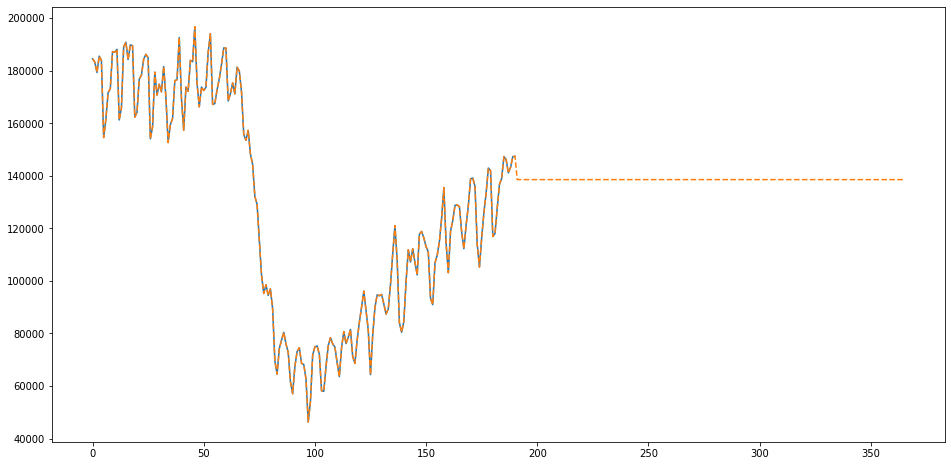

In [6]:
plt.figure(figsize=(16, 8))
plt.plot(range(len(flights_change["Number of flights"])), flights_change["Number of flights"])
plt.plot(range(366), flights_list, linestyle="--")

In [7]:
flights = pd.DataFrame({"Flights": flights_list, "month": None})
flights

,Flights,month
0,184566.000000,None
1,183328.000000,None
2,179306.000000,None
3,185552.000000,None
4,183890.000000,None
...,...,...
361,138559.695726,None
362,138559.695726,None
363,138559.695726,None
364,138559.695726,None


In [8]:
flights["date"] = [date(year = 2020, month = 1, day =6) + timedelta(days=i) for i in flights.index]
flights["month"] = [i.month for i in flights["date"]]
flights["date"]

0      2020-01-06
1      2020-01-07
2      2020-01-08
3      2020-01-09
4      2020-01-10
          ...    
361    2021-01-01
362    2021-01-02
363    2021-01-03
364    2021-01-04
365    2021-01-05
Name: date, Length: 366, dtype: object

In [9]:
monthly_flight_chng = flights.groupby("month").mean() / flights0
monthly_flight_chng

,Flights
month,
1,0.963726
2,0.969684
3,0.774975
4,0.389300
5,0.514691
6,0.662653
7,0.773216
8,0.775102
9,0.775102


## Add interpolated years
To ensure that 2020 is anomalous, we will interpolate the expected values from 2019, 2021, 2022 and 2023 before modifying 2020. 

In [10]:
# Since the data is extensive, we will cut it up first
start = datetime.now()
data = cutoff_netcdf_time(input_folder, output_folder, nox_input, tcutoff, scenario_string="", compress=False)
end = datetime.now()
print(end - start)

0:00:09.106805


In [11]:
start = datetime.now()
for yeardif in yeardif_to_interpolate:
    for i in range(1,13):
        insert_interpolated_point(data, yeardif * 365 + data.variables["time"][(i - 1)], 12, i)
    end = datetime.now()
    print(end - start)
    print("Inserted data for {}".format(yeardif))

0:00:53.399218
Inserted data for 1
0:01:50.452913
Inserted data for 2
0:02:50.856724
Inserted data for 3
0:03:51.396237
Inserted data for 4
0:04:37.447865
Inserted data for 6
0:05:22.771282
Inserted data for 7
0:06:09.623739
Inserted data for 8
0:06:55.218307
Inserted data for 9
0:07:40.693408
Inserted data for 10


# Perform the emissions modifications
We reduce the emissions in 2020 by a continuously changing amount, and the emissions in 2021 by a constant amount. First we copy and compress the interpolated data, then we modify it as a separate file. 

In [12]:
data.close()
data = copy_netcdf_file(
        "cut_" + nox_input, output_folder, output_folder, "_baseline" + version_str, compress=True
)
data.close()

In [13]:
data = copy_netcdf_file(
        "cut_" + nox_input, output_folder, output_folder, working_string, compress=False
)
output = data.variables[key_variable][:]
for time in range(1, 13):
    timeind = np.where(
        abs(data.variables["time"][:] - convert_years_to_days(2020 + (time - 0.5)/12)) == min(
            abs(data.variables["time"][:] - convert_years_to_days(2020 + (time - 0.5)/12))
        )
    )
    output[:, timeind, ...] *= monthly_flight_chng["Flights"].loc[time]
    timeind = np.where(
        abs(data.variables["time"][:] - convert_years_to_days(2021 + (time - 0.5)/12)) == min(
            abs(data.variables["time"][:] - convert_years_to_days(2021 + (time - 0.5)/12))
        )
    )    
    output[:, timeind, ...] *= monthly_flight_chng["Flights"].iloc[-1]

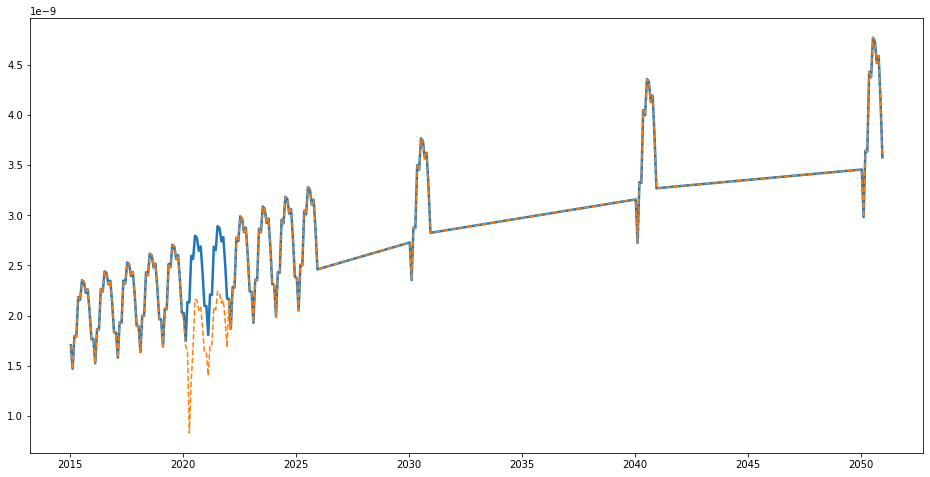

In [14]:
plt.figure(figsize=(16, 8))
plt.plot(data.variables["time"][:] / 365 + 2015, data.variables[key_variable][0, :, 283, 360], linewidth=2.5)
plt.plot(data.variables["time"][:] / 365 + 2015, output[0, :, 283, 360],  linestyle="--")

In [15]:
data.variables[key_variable][...] = output[...]
data.close()
# We also want to compress the data again
data = copy_netcdf_file(
    "cut_" + nox_input + working_string, output_folder, output_folder, 
    scenario_string + version_str, compress=True, remove_string=working_string
)

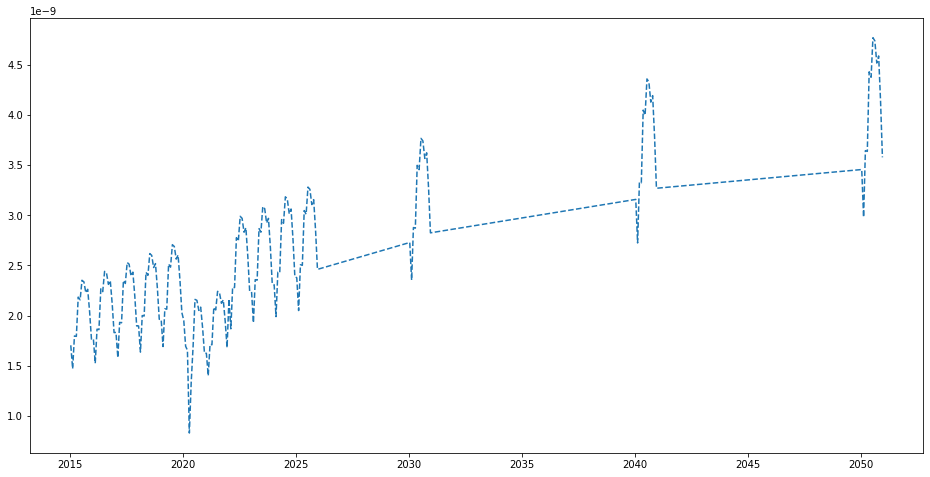

In [16]:
plt.figure(figsize=(16, 8))
plt.plot(data.variables["time"][:] / 365 + 2015, output[0, :, 283, 360],  linestyle="--")

In [17]:
data.close()

In [18]:
# This function will delete the files we don't want
cleanup_files(output_folder, working_string, scenario_string)

Deleting files ['cut_CO2-em-AIR-anthro_input4MIPs_emissions_ScenarioMIP_IAMC-MESSAGE-GLOBIOM-ssp245-1-1_gn_201501-210012.nc_workings']


In [19]:
data = nc.Dataset(input_folder + nox_input)
data2 = nc.Dataset(output_folder + "cut_CO2-em-AIR-anthro_input4MIPs_emissions_ScenarioMIP_IAMC-MESSAGE-GLOBIOM-ssp245-1-1_gn_201501-210012.nc_baseline_v4.nc")

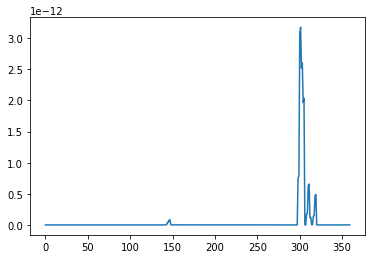

In [20]:
i = 12
plt.plot(data.variables["CO2_em_AIR_anthro"][i, 12, :, 60] - data2.variables["CO2_em_AIR_anthro"][i, 12*2, :, 60])